# Упражнение Softmax

Это упражнение аналогично упражнению SVM. В нём вы:

- реализуете полностью векторизированную **функцию потерь** для Softmax-классификатора;
- реализуете полностью векторизированное выражение для его **аналитического градиента**;
- **проверите свою реализацию** с помощью числового градиента;
- будете использовать валидационный набор для **настройки скорости обучения и силы регуляризации**;
- **оптимизируете** функцию потерь с помощью **SGD**;
- **визуализируете** итоговые обученные веса.

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

from cs231n.data_utils import load_CIFAR10
%matplotlib inline

plt.rcParams["figure.figsize"] = (10.0, 8.0)  # установим размер графиков по умолчанию
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

# для автоматической перезагрузки внешних модулей
# Смотри http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Загружает набор данных CIFAR-10 с диска и выполняет предварительную обработку,
    чтобы подготовить его для линейного классификатора. Это те же шаги, которые
    мы использовали для SVM, но сведены к одной функции.
    """
    # Загрузим необработанный набор данных CIFAR-10
    cifar10_dir = os.path.join("cs231n", "datasets", "cifar-10-batches-py")
    
    # Очистка переменных для предотвращения многократной загрузки данных (что может вызвать проблемы с памятью)
    try:
        del X_train, y_train
        del X_test, y_test
        print("Ранее загруженные данные очищены.")
    except:
        pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Подвыборка данных
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Предварительная обработка: преобразование изображений в строки
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Нормализация: вычетание среднего арифметического изображения
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # Добавление размерности смещения и преобразование в столбцы
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Вызываем указанную выше функцию, чтобы получить наши данные.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print("Форма обучающих данных:     ", X_train.shape)
print("Форма обучающих меток:      ", y_train.shape)
print("Форма валидационных данных: ", X_val.shape)
print("Форма валидационных меток:  ", y_val.shape)
print("Форма тестовых данных:      ", X_test.shape)
print("Форма тестовых меток:       ", y_test.shape)
print("Форма данных для разработки:", X_dev.shape)
print("Форма меток для разработки: ", y_dev.shape)

Форма обучающих данных:      (49000, 3073)
Форма обучающих меток:       (49000,)
Форма валидационных данных:  (1000, 3073)
Форма валидационных меток:   (1000,)
Форма тестовых данных:       (1000, 3073)
Форма тестовых меток:        (1000,)
Форма данных для разработки: (500, 3073)
Форма меток для разработки:  (500,)


## Softmax-классификатор

Для этого раздела вы будете писать код в `cs231n/classifiers/softmax.py`.

In [3]:
# Сначала реализуйте наивную функцию потерь softmax с вложенными циклами.
# Откройте файл cs231n/classifiers/softmax.py и реализуйте функцию softmax_loss_naive.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Создадим случайную матрицу весов softmax и используем её для вычисления потерь.
W = np.random.randn(3073, 10) * 0.0001
loss, _ = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# В качестве грубой проверки, наши потери должны быть близки к -log(0.1).
print("Потери: %f." % loss)
print("Проверка: %f." % (-np.log(0.1)))

Потери: 2.372698.
Проверка: 2.302585.


In [4]:
# Завершите реализацию softmax_loss_naive и реализуйте (наивную) версию
# расчёта градиента, использующую вложенные циклы.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# Как и в случае с SVM, используем числовой градиент для проверки.
# Числовой градиент должен быть близок к аналитическому.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# Как и в случае с SVM, сделаем ещё одну проверку градиента с регуляризацией.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

Проверка началась.
Численный: -1.392037, аналитический: -1.392037, относительная ошибка: 1.870974e-08
Численный: -3.968495, аналитический: -3.968495, относительная ошибка: 8.256897e-09
Численный: 2.044554, аналитический: 2.044554, относительная ошибка: 5.358163e-10
Численный: -1.033012, аналитический: -1.033012, относительная ошибка: 3.690097e-08
Численный: -0.863942, аналитический: -0.863942, относительная ошибка: 2.174410e-08
Численный: 0.072511, аналитический: 0.072511, относительная ошибка: 1.190967e-07
Численный: 0.275696, аналитический: 0.275696, относительная ошибка: 1.559270e-07
Численный: -1.163610, аналитический: -1.163610, относительная ошибка: 1.278777e-08
Численный: 1.869997, аналитический: 1.869997, относительная ошибка: 1.204940e-08
Численный: 0.762505, аналитический: 0.762505, относительная ошибка: 6.768809e-10
Проверка закончилась.
Проверка началась.
Численный: 4.581601, аналитический: 4.582689, относительная ошибка: 1.187989e-04
Численный: 0.288640, аналитический: 0.2

In [5]:
# Теперь, когда у нас есть наивная реализация функции потерь softmax и ее градиента,
# реализуйте векторизованную версию в softmax_loss_vectorized.
# Обе версии должны давать одинаковые результаты, но векторизованная версия должна
# быть намного быстрее.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print("Наивная потеря: %e вычислена за %fs секунд." % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print("Векторизованная потеря: %e вычислена за %fs секунд." % (loss_vectorized, toc - tic))

# Как и для SVM, мы используем норму Фробениуса для сравнения двух версий градиента.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord="fro")
print("Разница потерь: %f." % np.abs(loss_naive - loss_vectorized))
print("Разница градиентов: %f." % grad_difference)

Наивная потеря: 2.372698e+00 вычислена за 0.155902s секунд.
Векторизованная потеря: 2.372698e+00 вычислена за 0.009999s секунд.
Разница потерь: 0.000000.
Разница градиентов: 0.000000.


In [6]:
# Используем валидационный набор для настройки гиперпараметров (силы регуляризации
# и скорости обучения). Вам следует поэкспериментировать с различными диапазонами
# для скорости обучения и силы регуляризации; если вы постараетесь, вы сможете
# получить точность классификации около 0,35 для валидационного набора.

from cs231n.classifiers import Softmax
results = {}
best_val_accuracy = -1
best_softmax = None

# **************************** ЗАДАНИЕ **************************** #
# Используйте валидационный набор, чтобы установить скорость        #
# обучения и силу регуляризации. Это должно быть идентично          #
# валидации, которую вы выполнили для SVM; лучше всего обученный    #
# классификатор softmax сохраните в best_softmax.                   #

# Предоставляется для примера. Вы можете изменить эти гиперпараметры,
# а можете и не менять.
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

# *********************** НАЧАЛО МОЕГО КОДА *********************** #
NUM_TRIES = 100
# Перебор значений для скорости обучения и силы регуляризации не по сетке,
# а по случайному распределению.
for _ in range(NUM_TRIES):
    # выбираем значение скорости обучения случайным образом из заданного диапазона
    lr = np.random.uniform(learning_rates[0], learning_rates[1])
    # выбираем значение силы регуляризации случайным образом из заданного диапазона
    rs = np.random.uniform(regularization_strengths[0], regularization_strengths[1])
    
    # создаём новый экземпляр класса Softmax
    softmax = Softmax()
    # обучаем его
    softmax.train(X_train, y_train, learning_rate=lr, reg=rs, verbose=False)
    
    # получаем предсказания для обучающей части
    y_train_pred = softmax.predict(X_train)
    # вычисляем точность для обучающей части
    train_accuracy = np.mean(y_train_pred == y_train)
        
    # получаем предсказания для валидационной части
    y_val_pred = softmax.predict(X_val)
    # вычисляем точность для валидационной части
    val_accuracy = np.mean(y_val_pred == y_val)
    
    # сохраняем результаты    
    results[(lr, rs)] = (train_accuracy, val_accuracy)
    if best_val_accuracy < val_accuracy:
        best_val_accuracy = val_accuracy
        best_softmax = softmax
# *********************** КОНЕЦ МОЕГО КОДА ************************ #
    
# Распечатаем результаты
for lr, rs in sorted(results):
    train_accuracy, val_accuracy = results[(lr, rs)]
    print("Скорость обучения: %e.      Силы регуляризации %e." % (lr, rs))
    print("Точность на обучающем наборе: {:2.2%}. Точность на валидационном наборе: {:2.2%}.".format(
        train_accuracy, val_accuracy)
    )
    print("-------------------------------------------------------------------------------")
    
print("Лучшая точность на валидационном наборе: {:2.2%}".format(best_val_accuracy))

Скорость обучения: 1.045920e-07.      Силы регуляризации 3.655031e+04.
Точность на обучающем наборе: 15.04%. Точность на валидационном наборе: 16.30%.
-------------------------------------------------------------------------------
Скорость обучения: 1.103065e-07.      Силы регуляризации 4.832113e+04.
Точность на обучающем наборе: 15.91%. Точность на валидационном наборе: 14.80%.
-------------------------------------------------------------------------------
Скорость обучения: 1.184934e-07.      Силы регуляризации 4.149481e+04.
Точность на обучающем наборе: 15.88%. Точность на валидационном наборе: 15.30%.
-------------------------------------------------------------------------------
Скорость обучения: 1.223536e-07.      Силы регуляризации 4.793458e+04.
Точность на обучающем наборе: 18.58%. Точность на валидационном наборе: 17.10%.
-------------------------------------------------------------------------------
Скорость обучения: 1.242770e-07.      Силы регуляризации 3.035062e+04.
Точно

In [7]:
# Оценим лучший softmax на тестовом наборе
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print("Окончательная оценка точности Softmax на тестовой части: {:2.2%}.".format(test_accuracy))

Окончательная оценка точности Softmax на тестовой части: 31.00%.


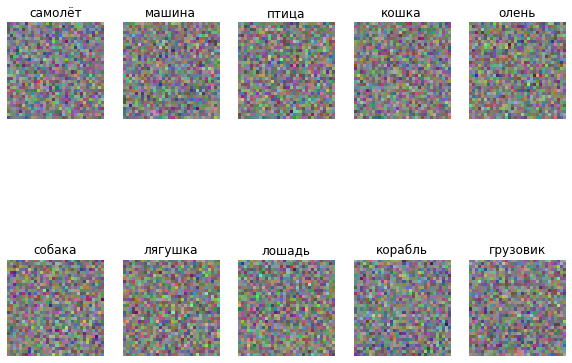

In [8]:
# Визуализируем обученные веса каждого класса.
w = best_softmax.W[:-1, :]  # отбросим смещение
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ["самолёт", "машина", "птица", "кошка", "олень", "собака", "лягушка", "лошадь", "корабль", "грузовик"]
for i in range(10):
    plt.subplot(2, 5, i + 1)
    # Изменим значения весов до диапазона от 0 до 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype("uint8"))
    plt.axis("off")
    plt.title(classes[i])